# **MINSHU DUBEY**
# Project 7

## Part I: RNN/LSTM/GRU
### In this exercise, you are to work in your previous group on stock market forecast. Collect performance data for a period of 12 months for a favorite stock (Apple, Google, etc.) and perform the following tasks:

### 1) Use the most accurate model (LSTM or GRU) that best predicts the collected data pertaining to the past 12 months. Pay special attention to the selected units, activation functions, dropouts, dense layer configuration, etc.

### 2) Use your model from part 1 to make predictions for the next month, next 5 months, and the next 10 months.

### 3) Make sure to plot your results in both parts 1 and 2.

### 4) Fully discuss and justify your results.


## **Libraries and Setup**

In [0]:
!pip install tensorflow==1.14.0

In [0]:
import seaborn as sns
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
from sklearn import preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.layers.recurrent import GRU
from keras.models import load_model
import keras
import h5py
import requests
import math, time



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, 

## We load data on Google stock prices(around past 12 months).

In [0]:
import pandas as pd 
url = 'https://raw.githubusercontent.com/dnjhaha/AML/master/datasets/GOOG.csv'
goo = pd.read_csv(url,index_col="Date",parse_dates=True)
goo.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-05-01,1188.050049,1188.050049,1167.180054,1168.079956,1168.079956,2639200
2019-05-02,1167.760010,1174.189941,1155.001953,1162.609985,1162.609985,1944800
2019-05-03,1173.650024,1186.800049,1169.000000,1185.400024,1185.400024,1980700
2019-05-06,1166.260010,1190.849976,1166.260010,1189.390015,1189.390015,1563900
2019-05-07,1180.469971,1190.439941,1161.040039,1174.099976,1174.099976,1551400


### **Data Cleaning**
Checking if any values are null

In [0]:
#Data cleaning
goo.isna().any()

Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

In [0]:
print('There are {} number of days in the dataset.'.format(goo.shape[0]))

There are 253 number of days in the dataset.


### **DATASET ATTRIBUTES DESCRIPTION**
The “Open” column represents the opening price for shares that day ,
The “High” column represents the highest price shares reached that day ,
The “Low” column represents the lowest price shares reached that day ,
The "Close" coloumn represents the closing price for shares that day ,
The “Adj Close” column reflects the closing price of the stock in relation to other stock attributes ,
The "Volume" coloumn represents the volume at which the trading went.

In [0]:
goo.describe()

,Open,High,Low,Close,Adj Close,Volume
count,253.000000,253.000000,253.000000,253.000000,253.000000,2.530000e+02
mean,1244.955118,1258.067153,1233.160928,1246.333795,1246.333795,1.682523e+06
std,118.775649,118.183970,119.835508,119.044900,119.044900,8.146496e+05
min,1042.900024,1047.489990,1013.536011,1036.229980,1036.229980,3.475000e+05
25%,1147.359985,1169.660034,1139.400024,1152.319946,1152.319946,1.159800e+06
50%,1224.079956,1239.089966,1212.300049,1220.170044,1220.170044,1.444300e+06
75%,1327.699951,1335.529053,1314.280029,1320.699951,1320.699951,1.913300e+06
max,1525.069946,1532.105957,1521.400024,1526.689941,1526.689941,5.130600e+06


### **Data Visualization**

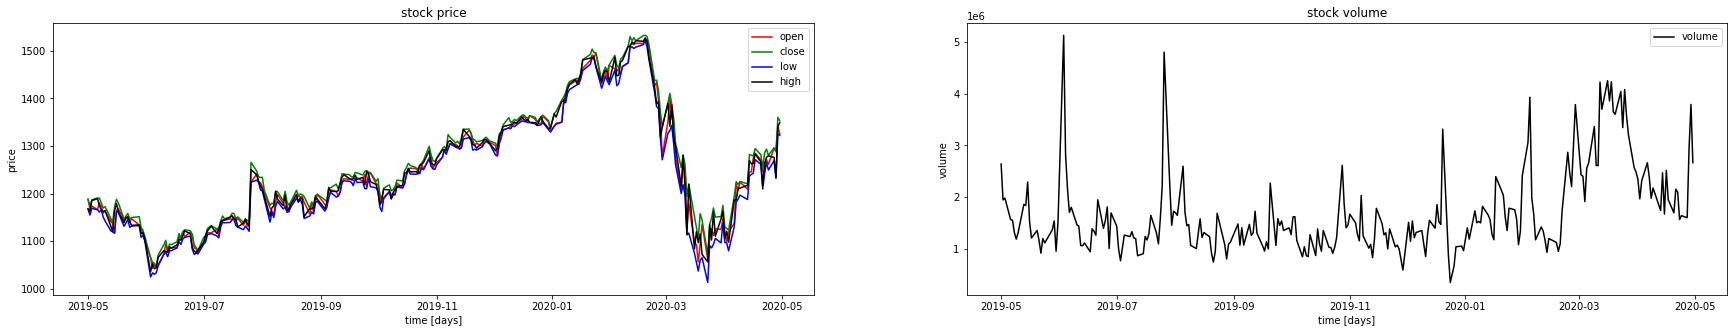

In [0]:
plt.figure(figsize=(30, 5));
plt.subplot(1,2,1);
plt.plot(goo["Open"], color='red', label='open')
plt.plot(goo["High"], color='green', label='close')
plt.plot(goo["Low"], color='blue', label='low')
plt.plot(goo["Close"], color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(goo["Volume"], color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

## **Data Scrubbing and Normalization**

**Data Manipulation** turns out to be dropping **Volume** and **Adj Close** coloumn because the main prediction of the Stock Market revolves around 4 main features **"Open" , "High" , "Low" & "Close"**.

Normalization is changing the values of numeric columns in the dataset to a common scale, which helps the performance of our model. To scale the training dataset we use Scikit-Learn’s MinMaxScaler with numbers between zero and one.



In [0]:
# function for min-max normalization of stock
def normalize_data(goo):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    goo['Open'] = min_max_scaler.fit_transform(goo.Open.values.reshape(-1,1))
    goo['High'] = min_max_scaler.fit_transform(goo.High.values.reshape(-1,1))
    goo['Low'] = min_max_scaler.fit_transform(goo.Low.values.reshape(-1,1))
    goo['Close'] = min_max_scaler.fit_transform(goo['Close'].values.reshape(-1,1))
    return goo


In [0]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns) # 5
    data = stock.to_numpy() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    result = np.array(result)

    row = round(0.9 * result.shape[0]) # 90% split
    train = result[:int(row), :] # 90% date, all features 
    
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [0]:
# choose one stock
goo_stock = goo.copy()
goo_stock.drop(['Adj Close'],1,inplace=True)
goo_stock.drop(['Volume'],1,inplace=True)

cols = list(goo_stock.columns.values)
print('goo_stock.columns.values = ', cols)

goo_stock.columns.values =  ['Open', 'High', 'Low', 'Close']


In [0]:
# normalize stock
goo_stock_norm = goo_stock.copy()
goo_stock_norm = normalize_data(goo_stock_norm)

## **Split the dataset into Train and Test**

In [0]:
# create train, test data
seq_len = 22 # choose sequence length
x_train, y_train, x_test, y_test = load_data(goo_stock_norm, seq_len)

print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)

print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (207, 22, 4)
y_train.shape =  (207,)
x_test.shape =  (23, 22, 4)
y_test.shape =  (23,)


### Data Visualisation after Normalizing and Cleaning Data 

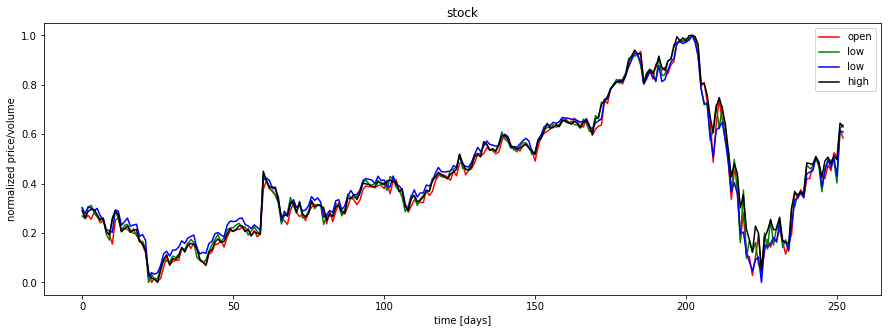

In [0]:
plt.figure(figsize=(15, 5));
plt.plot(goo_stock_norm.Open.values, color='red', label='open')
plt.plot(goo_stock_norm.Close.values, color='green', label='low')
plt.plot(goo_stock_norm.Low.values, color='blue', label='low')
plt.plot(goo_stock_norm.High.values, color='black', label='high')
#plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

## **Model Creation**

**LSTM MODEL:** The Long Short-Term Memory network, or LSTM network, is a recurrent neural network that is trained using Backpropagation Through Time and overcomes the vanishing gradient problem. LSTM networks have memory blocks that are connected through layers.

**GRU MODEL:** The GRU, known as the Gated Recurrent Unit is an RNN architecture, which is similar to LSTM units. The GRU comprises of the reset gate and the update gate instead of the input, output and forget gate of the LSTM.



### **LSTM**

In [0]:
def build_model(layers):
    d = 0.2
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    # adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

### **GRU**

In [0]:
def build_model_gru(layers):
    d = 0.2
    model_gru = Sequential()
    
    model_gru.add(GRU(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model_gru.add(Dropout(d))
        
    model_gru.add(GRU(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model_gru.add(Dropout(d))
        
    model_gru.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model_gru.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    # adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model_gru.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model_gru

Training LSTM Model

In [0]:
model = build_model([4,seq_len,1])

Compilation Time :  0.04528999328613281


In [0]:
lstm_his=model.fit(x_train,y_train,batch_size=32,epochs=20,validation_split=0.2,verbose=1)

Train on 165 samples, validate on 42 samples
Epoch 1/20
165/165 [==============================] - 1s 8ms/step - loss: 0.0238 - accuracy: 0.0061 - val_loss: 0.0846 - val_accuracy: 0.0238
Epoch 2/20
165/165 [==============================] - 1s 7ms/step - loss: 0.0104 - accuracy: 0.0061 - val_loss: 0.0950 - val_accuracy: 0.0238
Epoch 3/20
165/165 [==============================] - 1s 7ms/step - loss: 0.0123 - accuracy: 0.0061 - val_loss: 0.0748 - val_accuracy: 0.0238
Epoch 4/20
165/165 [==============================] - 1s 8ms/step - loss: 0.0099 - accuracy: 0.0061 - val_loss: 0.1073 - val_accuracy: 0.0238
Epoch 5/20
165/165 [==============================] - 1s 7ms/step - loss: 0.0065 - accuracy: 0.0061 - val_loss: 0.0929 - val_accuracy: 0.0238
Epoch 6/20
165/165 [==============================] - 1s 7ms/step - loss: 0.0055 - accuracy: 0.0061 - val_loss: 0.1034 - val_accuracy: 0.0238
Epoch 7/20
165/165 [==============================] - 1s 7ms/step - loss: 0.0052 - accuracy: 0.0061 - v

Training GRU Model

In [0]:
model_gru = build_model_gru([4,seq_len,1])

Compilation Time :  0.05484580993652344


In [0]:
gru_his=model_gru.fit(x_train,y_train,batch_size=32,epochs=20,validation_split=0.2,verbose=1)

Train on 165 samples, validate on 42 samples
Epoch 1/20
165/165 [==============================] - 3s 16ms/step - loss: 0.1704 - accuracy: 0.0061 - val_loss: 0.0522 - val_accuracy: 0.0238
Epoch 2/20
165/165 [==============================] - 1s 9ms/step - loss: 0.0282 - accuracy: 0.0061 - val_loss: 0.0555 - val_accuracy: 0.0238
Epoch 3/20
165/165 [==============================] - 1s 9ms/step - loss: 0.0145 - accuracy: 0.0061 - val_loss: 0.0368 - val_accuracy: 0.0238
Epoch 4/20
165/165 [==============================] - 1s 9ms/step - loss: 0.0101 - accuracy: 0.0061 - val_loss: 0.0312 - val_accuracy: 0.0238
Epoch 5/20
165/165 [==============================] - 1s 9ms/step - loss: 0.0066 - accuracy: 0.0061 - val_loss: 0.0278 - val_accuracy: 0.0238
Epoch 6/20
165/165 [==============================] - 1s 9ms/step - loss: 0.0056 - accuracy: 0.0061 - val_loss: 0.0270 - val_accuracy: 0.0238
Epoch 7/20
165/165 [==============================] - 1s 9ms/step - loss: 0.0043 - accuracy: 0.0061 - 

### Plotting the results of Training of both LSTM and GRU

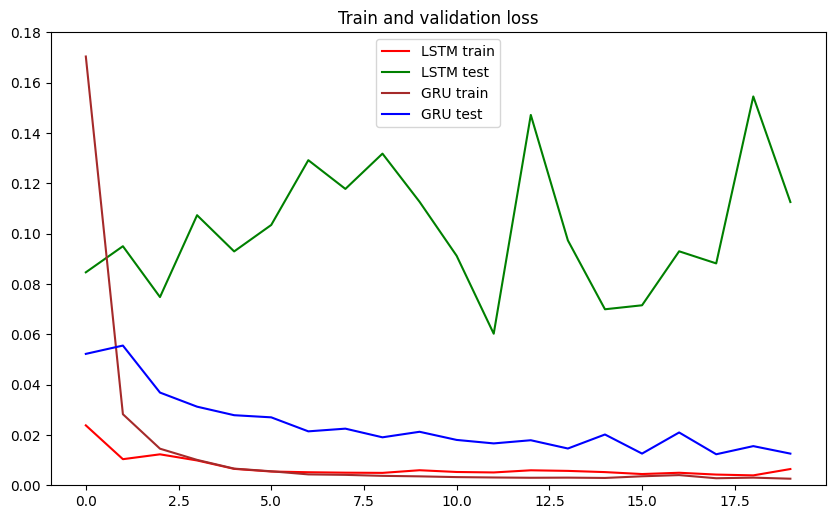

In [0]:
plt.figure(figsize=(10,6),dpi=100)
plt.plot(lstm_his.history['loss'],label='LSTM train',color='red')
plt.plot(lstm_his.history['val_loss'],label='LSTM test',color='green')
plt.plot(gru_his.history['loss'],label='GRU train',color='brown')
plt.plot(gru_his.history['val_loss'],label='GRU test',color='blue')
plt.xlabel=('epochs')
plt.ylabel=('loss')
plt.ylim((0,0.18))
plt.legend()
plt.title('Train and validation loss')
plt.show()

### Here, We can say after seeing graph results that LSTM Train loss << than Validation loss which means it is underfitting.  We did same with GRU and results were The Train Loss << Validation Loss  means underfitting

### **But GRU Model was less underfitted in comparison to LSTM model**

### **Evaluating Models**

In [0]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]


model_score(model, x_train, y_train, x_test, y_test)
model_score(model_gru, x_train, y_train, x_test, y_test)

Train Score: 0.02571 MSE (0.16 RMSE)
Test Score: 0.01151 MSE (0.11 RMSE)
Train Score: 0.00450 MSE (0.07 RMSE)
Test Score: 0.00782 MSE (0.09 RMSE)


(0.004497320935634023, 0.007820089347660542)

### **As GRU is less underfitted than LSTM we are taking GRU model for further Prediction in Stock Market**

In [0]:
diff=[]
ratio=[]
p = model_gru.predict(x_test)
print (p.shape)
# for each data index in test data
for u in range(len(y_test)):
    # pr = prediction day u
    pr = p[u][0]
    # (y_test day u / pr) - 1
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))



(23, 1)


In [0]:
#googl = pd.read_csv(url,index_col="Date",parse_dates=True)
def denormalize(goo, normalized_value): 
    goo = goo['Close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    #return goo.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(goo)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

newp = denormalize(goo, p)
newy_test = denormalize(goo, y_test)
#newy_test = denormalize(goo, y_test)

### **Predicting Stock Market for one month**

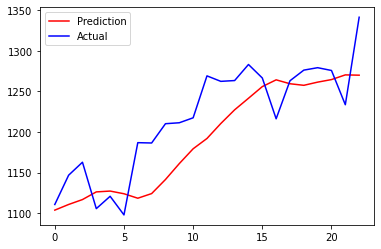

In [0]:
import matplotlib.pyplot as plt2


plt2.plot(newp,color='red', label='Prediction')
plt2.plot(newy_test,color='blue', label='Actual')

#plt2.plot(np.arange(y_train_pred.shape[0],y_train_pred.shape[0]+y_test_pred.shape[0]),newp,color='red', label='Prediction')
#plt2.plot(np.arange(y_train.shape[0],y_train.shape[0]+y_test.shape[0]),newy_test,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.show()

### **Predicting Stock Market for next 5 and 10 months**

In [0]:
diff=[]
ratio=[]
M = model_gru.predict(x_train)
print (M.shape)
# for each data index in test data
for u in range(len(y_train)):
    # pr = prediction day u
    pr = M[u][0]
    # (y_test day u / pr) - 1
    ratio.append((y_train[u]/pr)-1)
    diff.append(abs(y_train[u]- pr))



(207, 1)


In [0]:
ten = denormalize(goo, M)
ten_test = denormalize(goo, y_train)

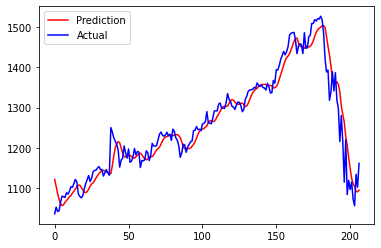

In [0]:
import matplotlib.pyplot as plt2


plt2.plot(ten,color='red', label='Prediction')
plt2.plot(ten_test,color='blue', label='Actual')

#plt2.plot(np.arange(y_train_pred.shape[0],y_train_pred.shape[0]+y_test_pred.shape[0]),newp,color='red', label='Prediction')
#plt2.plot(np.arange(y_train.shape[0],y_train.shape[0]+y_test.shape[0]),newy_test,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.show()

# **Conclusion**


### While doing prediction of next 5 and 10 months the exact price points from our predicted price were almost close to the actual Price.
### Though while predicting for next 1 month predicted points were'nt that close to the actual points,but our model did still indicate overall trends such as going up or down. This project teaches us how easily we can predict time series problem with models like GRU and LSTMs. Gru is better than  LSTM in computational efficiency also is a updated gate which needs less parameters and gates.
### But in predicting time series problems not only GRUs but even LSTM give effective results. 